In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/chest_xray

Mounted at /content/drive
densenet121_model_base.h5     densenet121_model_finetune.keras	train
densenet121_model_base.keras  test				TransferDenseNet121.ipynb


In [ ]:
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import random
import os

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [ ]:
#Data Prepare
main_path = "/content/drive/MyDrive/chest_xray"


train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [ ]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [ ]:
print(df_train)
print(df_test)

          class                                              image
0        Normal  /content/drive/MyDrive/chest_xray/train/NORMAL...
1        Normal  /content/drive/MyDrive/chest_xray/train/NORMAL...
2        Normal  /content/drive/MyDrive/chest_xray/train/NORMAL...
3        Normal  /content/drive/MyDrive/chest_xray/train/NORMAL...
4        Normal  /content/drive/MyDrive/chest_xray/train/NORMAL...
...         ...                                                ...
5227  Pneumonia  /content/drive/MyDrive/chest_xray/train/PNEUMO...
5228  Pneumonia  /content/drive/MyDrive/chest_xray/train/PNEUMO...
5229  Pneumonia  /content/drive/MyDrive/chest_xray/train/PNEUMO...
5230  Pneumonia  /content/drive/MyDrive/chest_xray/train/PNEUMO...
5231  Pneumonia  /content/drive/MyDrive/chest_xray/train/PNEUMO...

[5232 rows x 2 columns]
         class                                              image
0       Normal  /content/drive/MyDrive/chest_xray/test/NORMAL/...
1       Normal  /content/drive/MyDrive/

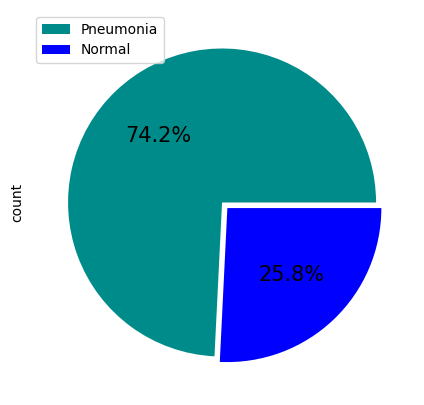

In [ ]:
plt.figure(figsize=(7,5))

df_train['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

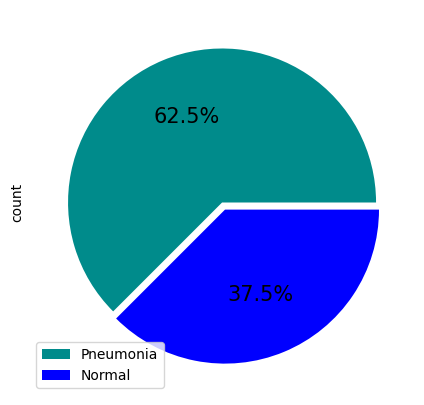

In [ ]:
plt.figure(figsize=(7,5))

df_test['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

In [ ]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, optimizers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['Recall'])

In [ ]:
history = model.fit(
    ds_train,
    epochs=50,
    validation_data=ds_val)

Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 114s 868ms/step - Recall: 0.9510 - loss: 0.2209 - val_Recall: 0.9550 - val_loss: 0.1860
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 111s 848ms/step - Recall: 0.9559 - loss: 0.1910 - val_Recall: 0.9550 - val_loss: 0.1693
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 117s 896ms/step - Recall: 0.9575 - loss: 0.1783 - val_Recall: 0.9485 - val_loss: 0.1610
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 110s 842ms/step - Recall: 0.9615 - loss: 0.1593 - val_Recall: 0.9099 - val_loss: 0.1865
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 109s 835ms/step - Recall: 0.9636 - loss: 0.1430 - val_Recall: 0.9382 - val_loss: 0.1493
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 109s 833ms/step - Recall: 0.9623 - loss: 0.1631 - val_Recall: 0.9331 - val_loss: 0.1444
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 111s 850ms/step - Recall: 0.9659 - loss: 0.1377 - val_Recall: 0.9318 - val_loss: 0.1512
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 112s 859ms/step - Recall: 0.9658 - loss: 0.1430 - val_Recall: 0.

In [ ]:
model.save("/content/drive/MyDrive/chest_xray/densenet121_model_base.keras")

In [ ]:
from tensorflow import keras

model = keras.models.load_model("/content/drive/MyDrive/chest_xray/densenet121_model_base.keras")


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/chest_xray/densenet121_model_finetune.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

In [ ]:
for layer in model.layers[-71:]:
    layer.trainable = True

# Giảm learning rate để tránh làm mất trọng số pretrained
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy', metrics=['Recall'])

# Tiếp tục train
model.fit(ds_train,
          epochs=10,
          validation_data=ds_val,
          callbacks=[early_stopping, checkpoint]
          )

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - Recall: 0.9607 - loss: 0.3001 - val_Recall: 0.9910 - val_loss: 0.2395
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - Recall: 0.9659 - loss: 0.1285 - val_Recall: 0.9923 - val_loss: 0.3022
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - Recall: 0.9730 - loss: 0.0997 - val_Recall: 0.9537 - val_loss: 0.1408
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - Recall: 0.9765 - loss: 0.0777 - val_Recall: 0.9344 - val_loss: 0.1548
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - Recall: 0.9752 - loss: 0.0816 - val_Recall: 0.8958 - val_loss: 0.2697
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - Recall: 0.9822 - loss: 0.0595 - val_Recall: 0.8945 - val_loss: 0.2757
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - Recall: 0.9838 - loss: 0.0615 - val_Recall: 0.9202 - val_loss: 0.2104
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - Recall: 0.9920 - loss: 0.0444 - val_Recall: 0.9550 - val_loss: 0.1192


In [ ]:
test_loss, test_accuracy = model.evaluate(ds_test)
print("Test accuracy:", test_accuracy)

624/624 ━━━━━━━━━━━━━━━━━━━━ 360s 577ms/step - Recall: 0.6200 - loss: 0.1751
Test accuracy: 0.9871794581413269


In [ ]:
y_true = np.array(ds_test.classes)  # Nhãn thực tế
y_pred_probs = model.predict(ds_test)  # Dự đoán xác suất
y_pred = np.round(y_pred_probs).astype(int).flatten()  # Chuyển thành 0/1

624/624 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step


In [ ]:
from sklearn.metrics import recall_score
recall = recall_score(y_true, y_pred)
print(f"Recall: {recall:.4f}")


Recall: 0.9872


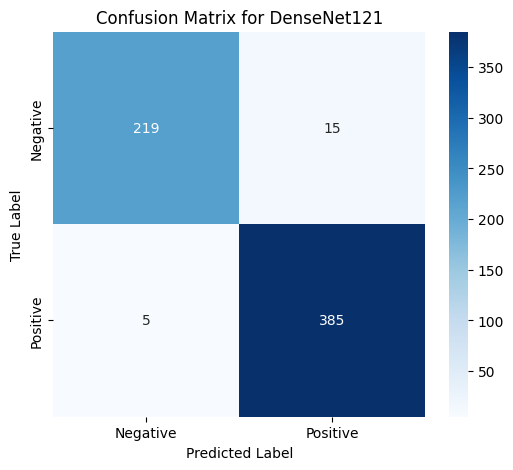

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)

# Vẽ heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for DenseNet121")
plt.show()

In [ ]:
bestmodel = keras.models.load_model("/content/drive/MyDrive/chest_xray/densenet121_model_finetune.keras")

In [ ]:
# prompt: Đánh gia best model bằng các thông số accuracry, recall, precision, F1-score và không vẽ confusion matrix

from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

# ... (previous code)

y_true = np.array(ds_test.classes)
y_pred_probs = bestmodel.predict(ds_test)
y_pred = np.round(y_pred_probs).astype(int).flatten()

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)


print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-score: {f1:.4f}")


624/624 ━━━━━━━━━━━━━━━━━━━━ 189s 304ms/step
Accuracy: 0.9679
Recall: 0.9872
Precision: 0.9625
F1-score: 0.9747


In [ ]:
y_true = np.array(ds_test.classes)  # Nhãn thực tế
y_pred_probs = bestmodel.predict(ds_test)  # Dự đoán xác suất


624/624 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step


In [ ]:
threshold = 0.5
y_pred = (y_pred_probs >= threshold).astype(int).flatten()

In [ ]:
from sklearn.metrics import recall_score
recall = recall_score(y_true, y_pred)
print(f"Recall: {recall:.4f}")

Recall: 0.9872


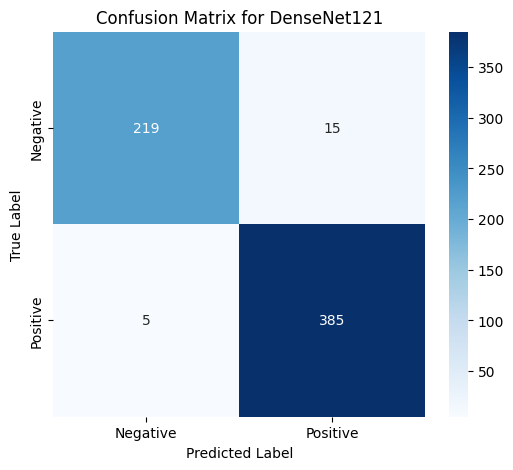

In [ ]:
cm = confusion_matrix(y_true, y_pred)

# Vẽ heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for DenseNet121")
plt.show()